In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from fpdf import FPDF
import dataframe_image as dfi

ModuleNotFoundError: No module named 'dataframe_image'

In [2]:
#GUI
import plot_GUI as pg
gui = pg.gui()

In [3]:
#distance between single CSO Events --> 24 h
abstand = 60*24
#define year !!!!!
jahr = '2021'

In [4]:
#read level data
df = pd.read_excel('data_for_evaluation_python/PI-tags_CSO_wil_'+jahr+'.xlsx', skiprows=[0,1,2,3,5])
#read rain data
df2 = pd.read_excel('data_for_evaluation_python/BWB_rain_'+jahr+'_Python.xlsx', skiprows=[0,1,2,4])

In [5]:
df1 = df.copy()
dfR = df2.copy()
#crest level
df1['Schwelle RUE11'] = 32.88
df1['Schwelle RUE19+20'] = 33
df1['Schwelle Pegel RB'] = 32.5
#Prepare level data
df1['diff - 03.01 Wil - Menge Regelstrecke'] = df1['03.01 Wil - Menge Regelstrecke'].diff()
df1['diff - 03.01 Wil - Menge RB-Überlauf'] = df1['03.01 Wil - Menge RB-Überlauf'].diff()
#Prepare rain data
dfR['diff - Wil'] = dfR['03.01 Wil - Regenmesser'].diff()
dfR['diff - Wil a'] = dfR['03.08 Wil a - Regenmesser'].diff()
dfR['diff - Wil m'] = dfR['03.09 Wil m - Regenmesser'].diff()

In [6]:
#Plot data
def plot(CSO,Pegel,Schwelle,farbe):
    plt.plot(df1['Unnamed: 0'],df1[Pegel],c=farbe, zorder=1, label=Pegel)
    plt.plot(df1['Unnamed: 0'],df1[Schwelle],c=farbe, zorder=2, label=Schwelle)
    plt.plot(CSO['Unnamed: 0'],CSO[Schwelle],'o',c='red', zorder=3, label=Schwelle)

In [7]:
#Number of CSO Events at different crests
def anzahl(Pegel, Schwelle):
    df1[Pegel+'- CSO'] = np.where(df1[Pegel] > df1[Schwelle][1], 1, 0)
    df1[Pegel+'- Anzahl'] = np.where((df1[Pegel +'- CSO'] == 1) & (df1[Pegel +'- CSO'].rolling(abstand).sum()==1),1,0)
    number = df1[Pegel+'- Anzahl'].sum()
    CSO = df1.loc[df1[Pegel+'- Anzahl']==1]
    print('Number of CSO-Events '+ Pegel +':     '+ str(number))
    return(CSO)

In [8]:
#Number of CSO Events at different crests
CSO1 = anzahl('03.01 Wil - Pegel Zulaufkammer', 'Schwelle RUE11')
CSO2 = anzahl('03.01 Wil - Pegel RB', 'Schwelle Pegel RB')
CSO3 = anzahl('03.30 Wil s - Pegel Mischwasserkanal', 'Schwelle RUE19+20')

Number of CSO-Events 03.01 Wil - Pegel Zulaufkammer:     3
Number of CSO-Events 03.01 Wil - Pegel RB:     9
Number of CSO-Events 03.30 Wil s - Pegel Mischwasserkanal:     9


In [9]:
# Total number of CSO Events
CSO = CSO1.append(CSO2).append(CSO3)
CSO = CSO.sort_values(by=['Unnamed: 0'])
doppelte = []
for i in range(len(CSO)-1):
    if (CSO.iloc[i+1]['Unnamed: 0']-CSO.iloc[i]['Unnamed: 0']).total_seconds() / 60 < abstand:
        doppelte.append(CSO.index[i])
CSO = CSO.drop(doppelte)
print('Anzahl CSO:   '+ str(CSO.shape[0]))

Anzahl CSO:   13


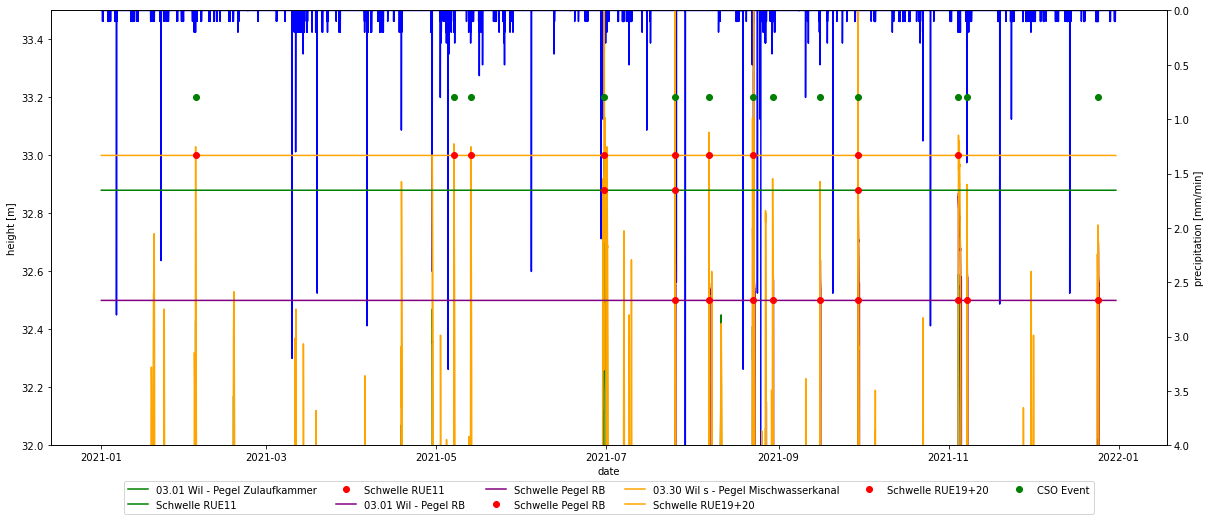

In [10]:
# Plot data
fig, ax1 = plt.subplots(figsize=(20,8))
#plt.title('Overview CSO Events '+jahr)
plot(CSO1,'03.01 Wil - Pegel Zulaufkammer', 'Schwelle RUE11', 'green')
plot(CSO2,'03.01 Wil - Pegel RB', 'Schwelle Pegel RB', 'purple')
plot(CSO3,'03.30 Wil s - Pegel Mischwasserkanal', 'Schwelle RUE19+20', 'orange')
plt.plot(CSO['Unnamed: 0'], [33.2]*CSO.shape[0], 'o', c='green',label='CSO Event')
plt.ylim(32.0,33.5)
ax2 = ax1.twinx()
ax2.plot(dfR['Unnamed: 0'],dfR['diff - Wil'],c='blue',label='Regen')
ax2.set_ylim(4,0)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),ncol=6)
ax1.set_xlabel('date')
ax1.set_ylabel('height [m]')
ax2.set_ylabel('precipitation [mm/min]')
bbox = matplotlib.transforms.Bbox([[0, -0.36], [20, 8]])
plt.savefig('CSO_Events_'+jahr+'.png', bbox_inches =bbox)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
gui.show(fig)

In [11]:
#create pdf overview
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(200, 10, txt = jahr+' - Evaluation CSO Events', ln = 1, align = 'C')
pdf.set_font("Arial", size = 11)
pdf.cell(200, 10, txt = "Total number of CSO Events: "+str(CSO.shape[0]), ln = 2, align = 'l')
pdf.cell(200, 10, txt = "      -   RUE11 number of CSO Events: "+str(CSO1.shape[0]), ln = 2, align = 'l')
pdf.cell(200, 10, txt = "      -   RUE19 and RUE20 number of CSO Events: "+str(CSO3.shape[0]), ln = 2, align = 'l')
pdf.cell(200, 10, txt = "      -   Pegel RB number of CSO Events: "+str(CSO2.shape[0]), ln = 2, align = 'l')
pdf.set_font('Arial', 'B', 11)
pdf.cell(200, 10, txt = "Overview: ", ln = 2, align = 'l')
pdf.image('CSO_Events_'+jahr+'.png', w=200)

pdf.set_font("Arial", size = 11)
pdf.cell(200, 10, txt = 'Date of CSO Events (green points):', ln = 2, align = 'l')
for i in range(len(CSO)):
    pdf.cell(txt = str(CSO['Unnamed: 0'].iloc[i]),w=45 , h = 5, border = 1, ln = 2, align = '', fill = False, link = '')

pdf.output('Evaluation CSO Evenst - '+jahr+'.pdf')

''

In [12]:
#GUI
gui.loop()